
Attempt 1:
Reading =  010110
Guessed Factors: 3 and 1
*** Non-trivial factor found: 3 ***


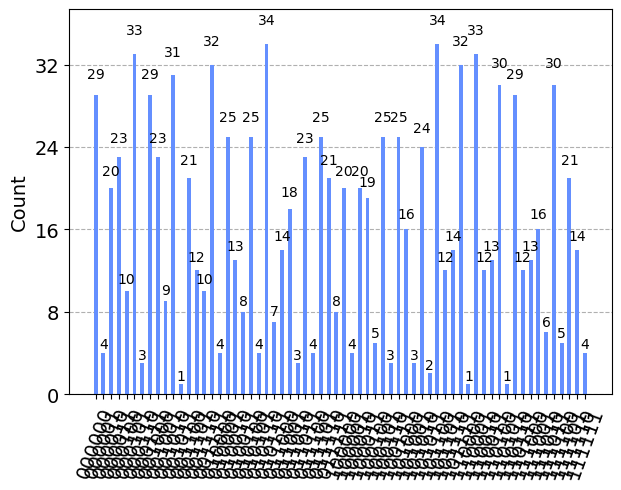

In [3]:
from qiskit import QuantumCircuit, Aer
from qiskit.visualization import plot_histogram
from math import gcd
from fractions import Fraction
from qiskit import *
from math import gcd # greatest common divisor
import numpy as np

def c_2mod21(power):
    """Controlled multiplication by a mod 21"""
    qreg_q = QuantumRegister(9, 'q')
    circuit = QuantumCircuit(qreg_q)
    for iteration in range(power):
        circuit.x(qreg_q[2])
        circuit.x(qreg_q[3])
        circuit.x(qreg_q[4])
        circuit.x(qreg_q[6])
        circuit.x(qreg_q[7])
        circuit.ccx(qreg_q[0], qreg_q[1], qreg_q[2])
        circuit.ccx(qreg_q[2], qreg_q[3], qreg_q[4])
        circuit.ccx(qreg_q[4], qreg_q[5], qreg_q[6])
        circuit.ccx(qreg_q[6], qreg_q[7], qreg_q[8])
        circuit.ccx(qreg_q[4], qreg_q[5], qreg_q[6])
        circuit.x(qreg_q[7])
        circuit.x(qreg_q[8])
        circuit.ccx(qreg_q[2], qreg_q[3], qreg_q[4])
        circuit.x(qreg_q[6])
        circuit.x(qreg_q[3])
        circuit.cx(qreg_q[8], qreg_q[3])
        circuit.ccx(qreg_q[2], qreg_q[3], qreg_q[4])
        circuit.cx(qreg_q[8], qreg_q[7])
        circuit.ccx(qreg_q[4], qreg_q[5], qreg_q[6])
        circuit.ccx(qreg_q[6], qreg_q[8], qreg_q[7])
        circuit.ccx(qreg_q[4], qreg_q[5], qreg_q[6])
        circuit.ccx(qreg_q[4], qreg_q[8], qreg_q[5])
        circuit.ccx(qreg_q[2], qreg_q[3], qreg_q[4])
        circuit.x(qreg_q[2])
        circuit.x(qreg_q[4])
        circuit.ccx(qreg_q[2], qreg_q[8], qreg_q[3])
        circuit.ccx(qreg_q[0], qreg_q[1], qreg_q[2])
        circuit.ccx(qreg_q[0], qreg_q[8], qreg_q[1])
        circuit.cx(qreg_q[8], qreg_q[0])
        circuit.swap(qreg_q[5], qreg_q[7])
        circuit.swap(qreg_q[3], qreg_q[5])
        circuit.swap(qreg_q[1], qreg_q[3])
        circuit.swap(qreg_q[0], qreg_q[1])
        circuit.cx(qreg_q[8], qreg_q[0])
        circuit.cx(qreg_q[0], qreg_q[8])
    
    circuit = circuit.to_gate()
    circuit.name = "2^%i mod 21" % (power)
    c_circuit = circuit.control()
    return c_circuit

def qft_dagger(n):
    """
    n-qubit QFT† for n qubits
    """
    qc = QuantumCircuit(n)  # Create a quantum circuit with n qubits
    # Swapping
    for qubit in range(n//2):
        qc.swap(qubit, n-qubit-1)  # Swap qubits symmetrically around the center
    qc.barrier()
    for j in range(n):
        for m in range(j):
            qc.cp(-np.pi/float(2**(j-m)), m, j)  # Apply controlled phase shift
        qc.h(j)  # Apply Hadamard gate
        qc.barrier()
    qc.name = "QFT†"  # Set the name of the circuit to "QFT†"
    return qc

def qpe_2mod21():
    n_count = 6  # Number of counting qubits
    qc = QuantumCircuit(9+n_count, n_count)  # Create a quantum circuit with 9+n_count qubits and n_count classical bits
    for q in range(n_count):
        qc.h(q)  # Apply Hadamard gate to initialize counting qubits in state |+>
    qc.x(8+n_count)  # Apply X-gate to auxiliary register in state |1>
    for q in range(n_count):  # Do controlled-U operations
        qc.append(c_2mod21(2**q), [q] + [i+n_count for i in range(9)])  # Append controlled multiplication gate
    qc.append(qft_dagger(n_count), range(n_count))  # Apply inverse-QFT
    qc.measure(range(n_count), range(n_count))  # Measure counting qubits

    # Run the circuit on a simulator
    backend = Aer.get_backend('qasm_simulator') 
    counts = execute(qc, backend, shots=1024).result().get_counts()

    # Analyze the measurement results to obtain the eigenvalue
    reading = max(counts, key=lambda x: counts[x])
    print("Reading = ", reading)
    phase = int(reading, 2) / 2**6
    return phase, counts

N = 21  # Number to be factored
a = 2  # Base for the modular exponentiation

factor_found = False
attempt = 0
while not factor_found:
    attempt += 1
    print("\nAttempt %i:" % attempt)
    phase, counts = qpe_2mod21()  # Perform quantum phase estimation
    frac = Fraction(phase).limit_denominator(N)  # Find the fraction approximation of the phase
    r = frac.denominator  # Obtain the denominator as the potential period
    if phase != 0:
        guesses = [gcd(a**(r//2)-1, N), gcd(a**(r//2)+1, N)]  # Guess potential factors using gcd
        print("Guessed Factors: %i and %i" % (guesses[0], guesses[1]))
        for guess in guesses:
            if guess not in [1, N] and (N % guess) == 0:  # Check if guess is a non-trivial factor
                print("*** Non-trivial factor found: %i ***" % guess)
                factor_found = True

plot_histogram(counts)  # Plot the histogram of measurement results